# GZ: Builder spiral comparisons

First, set up the environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Ellipse
from PIL import Image
from astropy.io import fits
from scipy.interpolate import splprep, splev, UnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
from skimage import img_as_float
from skimage.transform import rotate, rescale
from skimage.measure import compare_ssim as ssim
import astropy.units as u
from gzbuilderspirals import deprojecting as dpj
from gzbuilderspirals import fitting
from gzbuilderspirals import getDrawnArms, deprojectArm, rThetaFromXY, xyFromRTheta
from gzbuilderspirals.galaxySpirals import GalaxySpirals
import sdssCutoutGrab as scg
import createSubjectsFunctions as csf

In [3]:
print('Loading NSA catalog')
df_nsa = pd.read_pickle('NSA_filtered.pkl')

print('Loading Zooniverse classification dump')
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

print('Obtaining available frame montages')
# Some galaxies were montaged when created. Create a list of their coordinates for use later
montages = [f for f in os.listdir('montageOutputs') if not f[0] == '.']
montageCoordinates = np.array([
    [float(j) for j in i.replace('+', ' ').split(' ')]
    if '+' in i
    else [float(j) for j in i.replace('-', ' -').split(' ')]
    for i in [f for f in os.listdir('montageOutputs') if not f[0] == '.']
])

Loading NSA catalog
Loading Zooniverse classification dump
Obtaining available frame montages


In [4]:
subjectId = 20902041
sparcfire_pa = 17.74209509
sparcfire_sigma = 10.63146309

Working on galaxy 20902041
	- USING MONTAGED IMAGE
	- Getting galaxy rotation
[createWCSObject] Checking for transformation
[createWCSObject] Using CD
	- Downloading Zooniverse image
	- Deprojecting image
	- Extracting spiral annotations
Done!


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/tlingard/PhD/gzbuilderspirals/gzbuilderspirals/deprojecting.py:24: RuntimeWarning: cdelt will be ignored since cd is present
  fits_cdelt = wFits.wcs.cdelt
/Users/tlingard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


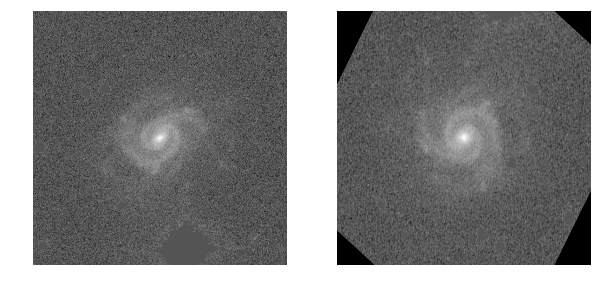

In [5]:
print('Working on galaxy {}'.format(subjectId))

# Grab the metadata of the subject we are working on
meta = eval(subjects[subjects['subject_id'] == subjectId].iloc[0]['metadata'])

# And the NSA data for the galaxy (if it's a galaxy with NSA data,
# otherwise throw an error)
try:
    gal = df_nsa[df_nsa['NSAID'] == int(meta['NSA id'])]
except KeyError:
    gal = {}
    raise KeyError('Metadata does not contain valid NSA id (probably an older galaxy)')

# Now we need to obtain the galaxy's rotation in Zooniverse image
# coordinates. This is made trickier by some decision in the subject
# creation pipeline.

# First, use a WCS object to obtain the rotation in pixel coordinates, as
# would be obtained from `fitsFile[0].data`

montagesDistanceMask = np.add.reduce(
    (montageCoordinates - [gal['RA'].iloc[0], gal['DEC'].iloc[0]])**2,
    axis=1
) < 0.01
usingMontage = np.any(montagesDistanceMask)
if usingMontage:
    montageFolder = montages[
        np.where(montagesDistanceMask)[0][0]
    ]
    fitsName = '{}/{}/{}'.format(
        os.path.abspath('montageOutputs'),
        montageFolder,
        'mosaic.fits'
    )
    print('\t- USING MONTAGED IMAGE')
else:
    fitsName = 'fitsImages/{0}/{1}/frame-r-{0:06d}-{1}-{2:04d}.fits'.format(
        int(gal['RUN']),
        int(gal['CAMCOL']),
        int(gal['FIELD'])
    )

print('\t- Getting galaxy rotation')
w = dpj.createWCSObject(gal, 512)
angle = dpj.getAngle(gal, fitsName, np.array([512, 512]))

print('\t- Downloading Zooniverse image')
# We'll now download the Zooniverse image that volunteers actually classified on
getUrl = lambda id: eval(subjects[subjects['subject_id'] == subjectId]['locations'].iloc[0])['1']
url = getUrl(subjectId)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

# Grab the data arrays from the Image objects, and imshow the images (for debugging purposes)
picArray = np.array(pic)

print('\t- Deprojecting image')
# Now deproject the image of the galaxy:
rotatedImage = rotate(picArray, angle)
stretchedImage = rescale(
    rotatedImage,
    (1/gal['SERSIC_BA'].iloc[0], 1),
    mode='constant',
    multichannel=False
)
n = int((stretchedImage.shape[0] - np.array(pic).shape[0]) / 2)
if n > 0:
    deprojectedImage = stretchedImage[n:-n, :]
else:
    deprojectedImage = stretchedImage.copy()

print('\t- Extracting spiral annotations')

# Extract the drawn arms from classifications for this galaxy
drawnArms = getDrawnArms(subjectId, classifications)
print('Done!')

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(picArray, origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(deprojectedImage, origin='lower', cmap='gray')
plt.axis('off')
None

In [6]:
s = GalaxySpirals(drawnArms, ba=gal['SERSIC_BA'].iloc[0], phi=-angle)

# Now calculate a the distance matrix for the drawn arms (this can be slow)
try:
    distances = np.load('distances/subject-{}.npy'.format(subjectId))
    print('Using saved distances')
except OSError:
    print('Calculating distances')
    distances = s.calculateDistances()
    np.save('distances/subject-{}.npy'.format(subjectId), distances)

# Perform the clustering (using the DBSCAN clustering algorithm)
db = s.clusterLines(distances)

Using saved distances


/Users/tlingard/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [7]:
galaxy_fit = s.fitArms()

/Users/tlingard/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


False
False
False
False
False
False


In [8]:
def fitSpline(deprojectedArm):
    sortingLine = deprojectedArm.getSortingLine()
    t = np.linspace(0, 1, sortingLine.shape[0])

    # order the arm along the deprojected XY fit
    o = deprojectedArm.orderAlongPolyLine(
        sortingLine
    )

    # calculate a strictly monotonic t array for points along this arm
    deprojectedT = deprojectedArm.genTFromOrdering(o)

    orderedDeprojectedCloud = (
        deprojectedArm.cleanedCloud[o['pointOrder']]
    )
    r_points, theta_points = rThetaFromXY(
        *deprojectedArm.normalise(orderedDeprojectedCloud).T,
        mux=0, muy=0
    )
    r_sorting, theta_sorting = rThetaFromXY(
        *(deprojectedArm.normalise(sortingLine).T)
    )

    thetaFunc = interp1d(t, theta_sorting)

    Sr = UnivariateSpline(deprojectedT, r_points / max(r_points), k=3)
    r_spline = Sr(t) * max(r_points)
    theta_spline = thetaFunc(t)
    xr, yr = xyFromRTheta(r_spline, theta_spline, mux=0, muy=0)

    return {
        'spline_x_y': np.stack((xr, yr), axis=1),
        'spline_r_theta': np.stack((r_spline, theta_spline), axis=1),
        'spline_t': t,
        'sortingLine': sortingLine,
        'points_r_theta': np.stack((r_points, theta_points), axis=1),
        'thetaFunc': thetaFunc,
        'points': deprojectedArm.normalise(deprojectedArm.cleanedCloud),
        'orderedDeprojectedCloud': orderedDeprojectedCloud,
        'deprojectedT': deprojectedT
    }
deprojectedArms = [arm.deproject(s.phi, s.ba) for arm in s.arms]
spline_fit_result = fitSpline(deprojectedArms[0])

/Users/tlingard/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Logarithmic spiral fit using Bayesian Ridge Regression

Now we have our ordered points in $(\theta, r)$, we can perform a linear bayesian ridge regression to obtain the log spiral.

Taking the log of the equation for a logarithmic spiral, we obtain
$$$
\log(r) = \log(a) + b\theta,
$$$

Therefore fitting a straight line to $\log(r)$ allows the recovery of $b$ as the gradient of the slope.

The data we'll fit to is the points' $(\theta, r)$ values, ordered by increasing theta (unwrapped and ordered inside the fitting function).

In [9]:
r_points, theta_points = spline_fit_result['points_r_theta'].T
r_ordered, theta_ordered = fitting.unwrapAndSortTheta(r_points, theta_points)

In [20]:
log_spiral_res = fitting.logSpiralFit(r_ordered, theta_ordered)

theta_log_spiral = log_spiral_res['theta']

r_log_spiral = log_spiral_res['r']
r_lower_log_spiral, r_upper_log_spiral = log_spiral_res['errors']

log_spiral_pa = 90 - np.rad2deg(np.arctan2(1, np.abs(log_spiral_res['clf'].coef_[0])))
log_spiral_sigma = 180 * np.sqrt(log_spiral_res['clf'].sigma_[0, 0]) / np.pi

Plot the results of the fit:

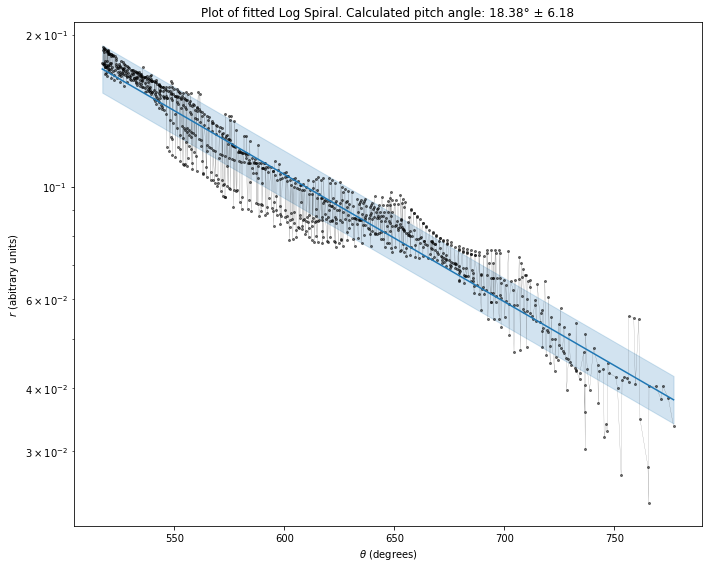

In [21]:
plt.figure(figsize=(10, 8))
theta_ordered_degrees = np.rad2deg(theta_ordered)
plt.plot(theta_ordered_degrees, r_ordered, 'k.-', markersize=4, linewidth=0.2, alpha=0.5)
plt.plot(theta_ordered_degrees, r_log_spiral)
plt.fill_between(
    theta_ordered_degrees,
    *log_spiral_res['errors'],
    alpha=0.2, color='C0'
)
plt.title('Plot of fitted Log Spiral. Calculated pitch angle: {:.2f}° ± {:.2f}'.format(
    log_spiral_pa, log_spiral_sigma
))
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('$r$ (abitrary units)')
plt.yscale('log')
plt.tight_layout()

## Spline fit using Bayesian Ridge Regression

As we wish to test whether a logarithmic spiral is an appropriate model for our galaxies, we will also perform a higher-order polynomial fit to $(t, r),$ using Bayesian Ridge Regression.

Note that $t$ is obtained through a point sorting method, and measures how far a point is along some "sorting line". It is monotonic with $\theta$ for a spiral which closely matches a logarithmic spiral.

In [12]:
T = spline_fit_result['deprojectedT']
T_predict = spline_fit_result['spline_t']

spline_spiral_res = fitting.splineSpiralFit(r_points, T, T_predict)

In [13]:
spline_spiral_res['clf'].coef_

array([-0.04982073,  0.11085196, -0.18941298,  0.        ])

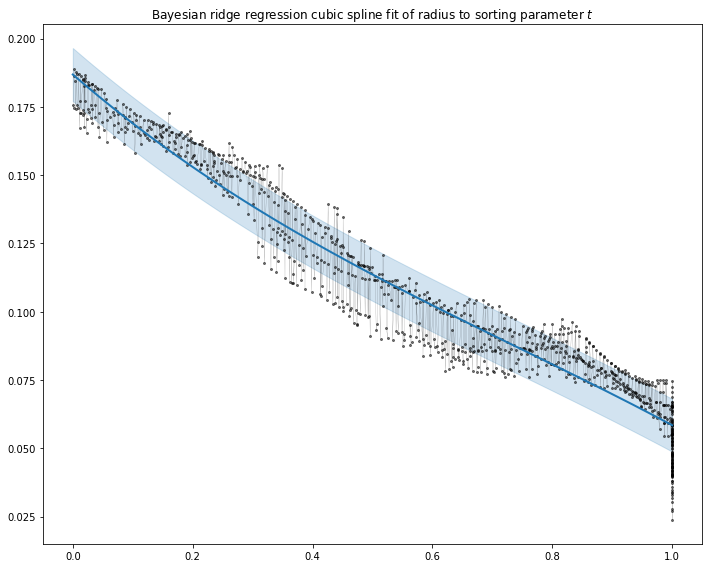

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(T, r_points, 'k.-', markersize=4, linewidth=0.2, alpha=0.5)
plt.fill_between(
    spline_spiral_res['tPredict'],
    *spline_spiral_res['errors'],
    alpha=0.2, color='C0'
)
plt.plot(
    spline_spiral_res['tPredict'], spline_spiral_res['r'],
    linewidth=2,
)
plt.title('Bayesian ridge regression cubic spline fit of radius to sorting parameter $t$')
plt.tight_layout()

In [15]:
theta_ = spline_fit_result['thetaFunc'](T_predict)

x_spline, y_spline = xyFromRTheta(spline_spiral_res['r'], theta_)
x_lower_spline, y_lower_spline = xyFromRTheta(spline_spiral_res['errors'][0], theta_)
x_upper_spline, y_upper_spline = xyFromRTheta(spline_spiral_res['errors'][1], theta_)

x_log_spiral, y_log_spiral = xyFromRTheta(r_log_spiral, theta_ordered)
x_lower_log_spiral, y_lower_log_spiral = xyFromRTheta(
    r_lower_log_spiral,
    theta_ordered
)
x_upper_log_spiral, y_upper_log_spiral = xyFromRTheta(
    r_upper_log_spiral,
    theta_ordered
)

## Getting pich angle measurements

Great, we've determined the two spirals are pretty consistent. Now what about their pitch angles?

We'll start by getting the pitch angle and error for the log spiral, using the data (rather than the fit coefficients as done above)

In [100]:
pitch_angle_spline = fitting.pitchAngleFromXY(x_spline, y_spline)
pitch_angle_lower_spline = fitting.pitchAngleFromXY(x_lower_spline, y_lower_spline)
pitch_angle_upper_spline = fitting.pitchAngleFromXY(x_upper_spline, y_upper_spline)

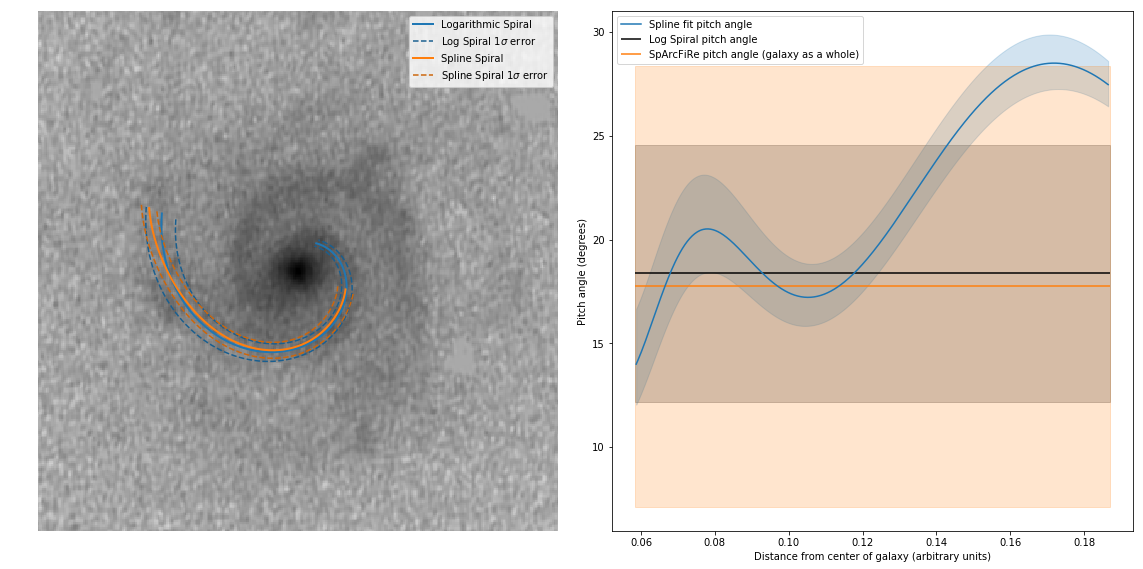

In [101]:
# plotting
plt.figure(figsize=(16, 8))

plt.subplot(121)
# show the galaxy
plt.imshow(deprojectedImage, cmap='gray_r', origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])

# plot the log spiral and errors
p = plt.plot(x_log_spiral, y_log_spiral, linewidth=2, label='Logarithmic Spiral')
c = np.array(to_rgb(p[0].get_color())) * 0.8
plt.plot(x_lower_log_spiral, y_lower_log_spiral, '--', c=c)
plt.plot(x_upper_log_spiral, y_upper_log_spiral, '--', c=c,
         label='Log Spiral $1\sigma$ error')

# plot the spline and errors
p = plt.plot(x_spline, y_spline, linewidth=2, label='Spline Spiral')
c = np.array(to_rgb(p[0].get_color())) * 0.8
plt.plot(x_lower_spline, y_lower_spline, '--', c=c, label='Spline Spiral $1\sigma$ error')
plt.plot(x_upper_spline, y_upper_spline, '--', c=c)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.axis('off')
plt.legend()
plt.tight_layout()

plt.subplot(122)

plt.hlines(log_spiral_pa, np.min(spline_spiral_res['r']), np.max(spline_spiral_res['r']), label='Log Spiral pitch angle')
plt.fill_between(
    spline_spiral_res['r'],
    log_spiral_pa - log_spiral_sigma,
    log_spiral_pa + log_spiral_sigma,
    alpha=0.2, color='k',
)

plt.plot(spline_spiral_res['r'][1:-1], pitch_angle_spline, label='Spline fit pitch angle')
plt.fill_between(
    spline_spiral_res['r'][1:-1],
    pitch_angle_lower_spline,
    pitch_angle_upper_spline,
    alpha=0.2, color='C0',
)

# plot SpArcFiRe's values
sparcfire_pa = 17.74209509
sparcfire_sigma = 10.63146309
plt.hlines(sparcfire_pa, np.min(spline_spiral_res['r']), np.max(spline_spiral_res['r']), 'C1', label='SpArcFiRe pitch angle (galaxy as a whole)')
plt.fill_between(
    spline_spiral_res['r'],
    sparcfire_pa - sparcfire_sigma,
    sparcfire_pa + sparcfire_sigma,
    alpha=0.2, color='C1',
)
plt.ylabel('Pitch angle (degrees)')
plt.xlabel('Distance from center of galaxy (arbitrary units)')
plt.legend()
plt.tight_layout()

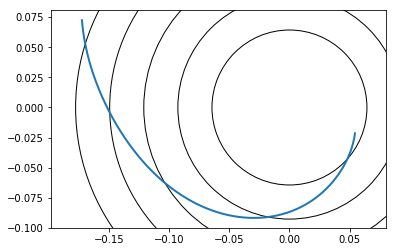

In [69]:
p = plt.plot(x_spline, y_spline, linewidth=2, label='Spline Spiral')
rs = np.sqrt(x_spline**2 + y_spline**2)
for r in np.linspace(np.min(rs)*1.1, np.max(rs)*0.95, 5):
    plt.gca().add_artist(Ellipse(
        xy=(0, 0),
        width=r*2,
        height=r*2,
        facecolor='none',
        edgecolor='k'
    ))
plt.axis('equal'); None

And now for the other arm (having written the above code into a function inside `gzbuilderspirals.fitting`)

In [18]:
arm2_result = deprojectedArms[1].fit()

False
False
False


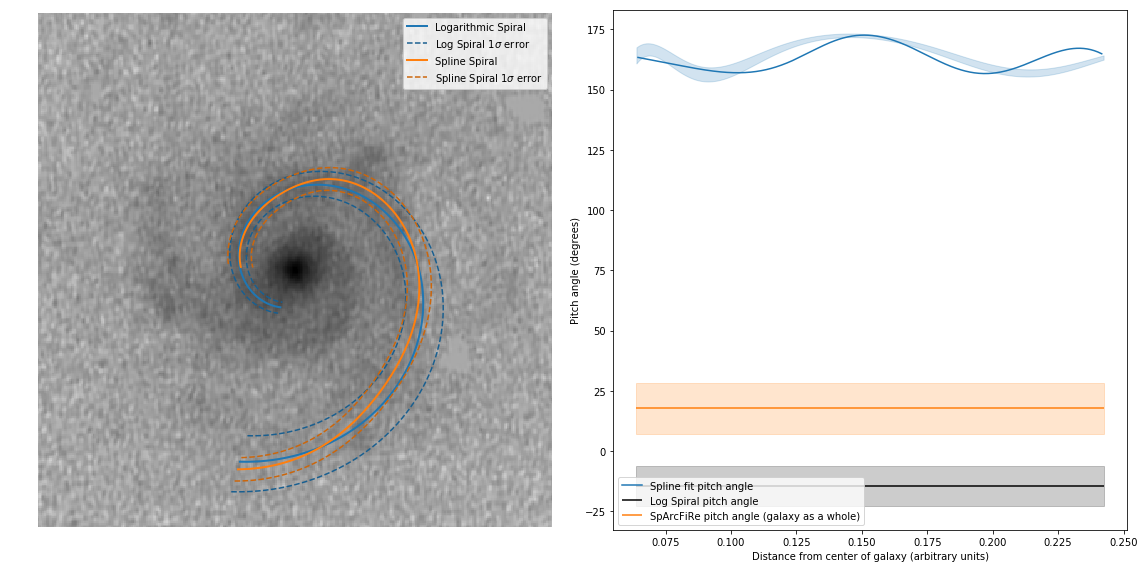

In [106]:
# plotting
plt.figure(figsize=(16, 8))

# Left panel: plot the spirals and errors over the galaxy image
plt.subplot(121)

# show the galaxy
plt.imshow(deprojectedImage, cmap='gray_r', origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])

# plot the log spiral and errors
p = plt.plot(
    *arm2_result['xy_fit']['log_spiral'].T,
    linewidth=2, label='Logarithmic Spiral'
)
c = np.array(to_rgb(p[0].get_color())) * 0.8
plt.plot(*arm2_result['xy_fit']['log_spiral_error'][0].T, '--', c=c)
plt.plot(*arm2_result['xy_fit']['log_spiral_error'][1].T, '--', c=c,
         label='Log Spiral $1\sigma$ error')

# plot the spline and errors
p = plt.plot(*arm2_result['xy_fit']['spline'].T, linewidth=2, label='Spline Spiral')
c = np.array(to_rgb(p[0].get_color())) * 0.8
plt.plot(*arm2_result['xy_fit']['spline_error'][0].T, '--', c=c)
plt.plot(*arm2_result['xy_fit']['spline_error'][1].T, '--', c=c,
        label='Spline Spiral $1\sigma$ error')

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.axis('off')
plt.legend()
plt.tight_layout()

plt.subplot(122)

pa_obj = arm2_result['pitch_angle']
r_bounds = (np.min(arm2_result['radial']['spline']['r']), np.max(arm2_result['radial']['spline']['r']))
plt.hlines(
    pa_obj['log_spiral'][0], *r_bounds, label='Log Spiral pitch angle')
plt.fill_between(
    arm2_result['radial']['spline']['r'],
    pa_obj['log_spiral'][0] - pa_obj['log_spiral'][1],
    pa_obj['log_spiral'][0] + pa_obj['log_spiral'][1],
    alpha=0.2, color='k',
)

plt.plot(arm2_result['radial']['spline']['r'][1:-1], pa_obj['spline'][0], label='Spline fit pitch angle')
plt.fill_between(
    np.linspace(
        np.min(arm2_result['radial']['spline']['r']),
        np.max(arm2_result['radial']['spline']['r']),
        pa_obj['spline'][1].shape[0]
    ),
    *pa_obj['spline'][1:],
    alpha=0.2, color='C0',
)

# plot SpArcFiRe's values
plt.hlines(sparcfire_pa, *r_bounds, 'C1', label='SpArcFiRe pitch angle (galaxy as a whole)')
plt.fill_between(
    arm2_result['radial']['spline']['r'],
    sparcfire_pa - sparcfire_sigma,
    sparcfire_pa + sparcfire_sigma,
    alpha=0.2, color='C1',
)
plt.ylabel('Pitch angle (degrees)')
plt.xlabel('Distance from center of galaxy (arbitrary units)')
plt.legend()
plt.tight_layout()